In [2]:
import torch
import torchio as tio

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import filters, segmentation, morphology, measure, transform

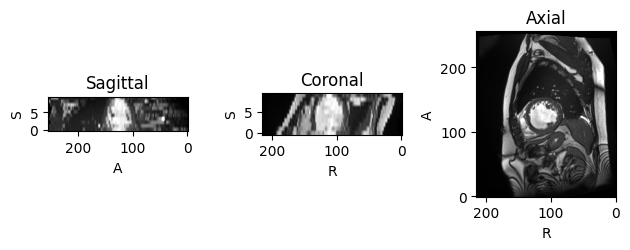

In [3]:
patient_1 = tio.Subject(
    t1=tio.ScalarImage('database/training/patient001/patient001_4d.nii.gz'),
    im1=tio.ScalarImage('database/training/patient001/patient001_frame01.nii.gz'),
    label1=tio.LabelMap('database/training/patient001/patient001_frame01_gt.nii.gz'),
    im2=tio.ScalarImage('database/training/patient001/patient001_frame12.nii.gz'),
    label2=tio.LabelMap('database/training/patient001/patient001_frame12_gt.nii.gz'),
)
# patient_1.im1.plot()
# patient_1.label1.plot()

patient_1.t1.shape
patient_1.t1.plot()

In [4]:
# On va essayer de faire une transformation de l'image

rescale = tio.RescaleIntensity(out_min_max=(0,1))
spatial = tio.OneOf({
        tio.RandomAffine(): 0.8,
        tio.RandomElasticDeformation(): 0.2,
    },
    p=0.75,
)

transforms = [rescale, spatial]
transform = tio.Compose(transforms)
transformed = transform(patient_1)
# transformed.im1.plot()

### Détermination de la seed

On va essayer d'implémenter le papier de Khened, et pour chaque image de trouver une seed situé à peu près au milieu du ventricule gauche.

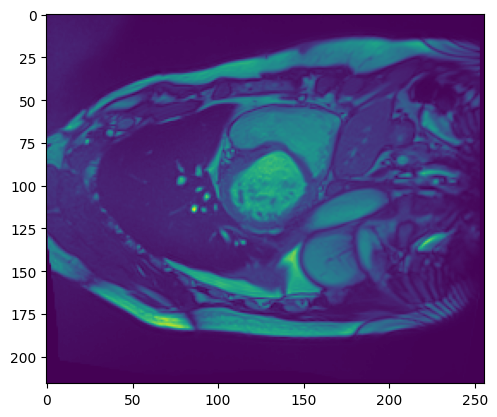

In [5]:
# On commence par load l'image d'un patient

patient = tio.Subject(
    t1=tio.ScalarImage('database/training/patient001/patient001_4d.nii.gz'),
    im1=tio.ScalarImage('database/training/patient001/patient001_frame01.nii.gz'),
    label1=tio.LabelMap('database/training/patient001/patient001_frame01_gt.nii.gz'),
    im2=tio.ScalarImage('database/training/patient001/patient001_frame12.nii.gz'),
    label2=tio.LabelMap('database/training/patient001/patient001_frame12_gt.nii.gz'),
)

data = patient.t1.data

# fig1,ax1 = plt.subplots(1,10, figsize=(20, 4))
# for i in range(10):
#     ax1[i].imshow(data[0,:,:,i], cmap='gray')
#     ax1[i].axis('off')
# fig2, ax2 = plt.subplots(1,10, figsize=(20, 4))
# for i in range(10):
#     ax2[i].imshow(data[29,:,:,i], cmap='gray')
#     ax2[i].axis('off')

plt.imshow(data[0,:,:,1])

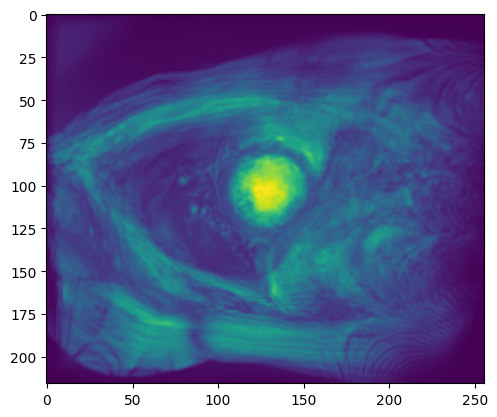

In [6]:
tf = np.fft.fftn(data[0,:,:,:], axes=[2])
mag = np.abs(tf)
plt.imshow(mag[:,:,0])

# On va conserver la composante de Hilbert :
pre_image = mag[:,:,0]

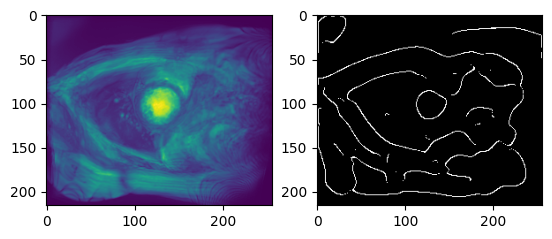

In [7]:
from skimage import feature
import cv2 as cv

edges = feature.canny(pre_image, sigma=9)
edges = (edges * 255).astype(np.uint8)
grey_edges = cv.cvtColor(edges, cv.COLOR_GRAY2BGR)
edges.shape
plt.subplot(121)
plt.imshow(pre_image)
plt.subplot(122)
plt.imshow(grey_edges)

No circles found


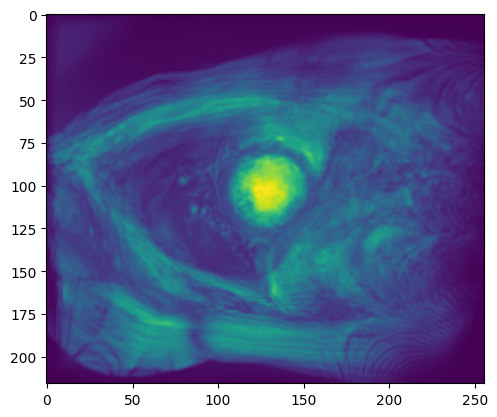

In [23]:
import cv2 as cv

circles=cv.HoughCircles(edges,cv.HOUGH_GRADIENT, 1, 5, param1=150, param2=30, minRadius=0, maxRadius=0)
if circles is not None:
    cercles = np.uint16(np.around(circles))
    for i in cercles[0,:]:
        cv.circle(pre_image, (i[0], i[1]), i[2], (0,255,0), 2)
        cv.circle(pre_image, (i[0], i[1]), 2, (0,0,255), 3)
else :
    print("No circles found")

plt.imshow(pre_image)
plt.show()
